# Effect of Adversarial Training on Simplicity Bias
Recall that we define extreme simplicity bias (SB) as the tendency of neural networks trained with SGD or variants to learn a small-margin classifier that exclusively relies on the simplest feature and remain invariant to all complex features.  In this notebook, we show that $\ell_{\infty}$ adversarial training does not mitigates simplicity bias on the MNIST-CIFAR dataset. For more details, please have a look at Appendix E.2 of the [paper](https://arxiv.org/abs/2006.07710). 

In [47]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from imports import *
from cifar10_models import cifar10_models as c10
DEVICE_ID = 0 # GPU_ID or None (CPU)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load and visualize MNIST-CIFAR data

In [48]:
# load standard, MNIST-randomized, CIFAR-randomized datasets
mnist_classes = (0, 1)
cifar_classes = (1, 9)
batch_size = 256

tr_dl, te_dl = mc_utils.get_mnist_cifar_dl(mnist_classes=mnist_classes, cifar_classes=cifar_classes, bs=batch_size, 
                                           randomize_mnist=False, randomize_cifar=False)

trm_dl, tem_dl = mc_utils.get_mnist_cifar_dl(mnist_classes=mnist_classes, cifar_classes=cifar_classes, bs=batch_size, 
                                             randomize_mnist=True, randomize_cifar=False)

trc_dl, tec_dl = mc_utils.get_mnist_cifar_dl(mnist_classes=mnist_classes, cifar_classes=cifar_classes, bs=batch_size, 
                                             randomize_mnist=False, randomize_cifar=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


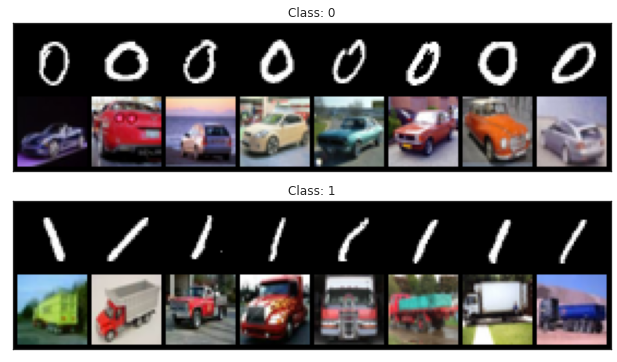

In [49]:
# visualize the standard dataset
_ = utils.visualize_loader_by_class(te_dl)
None

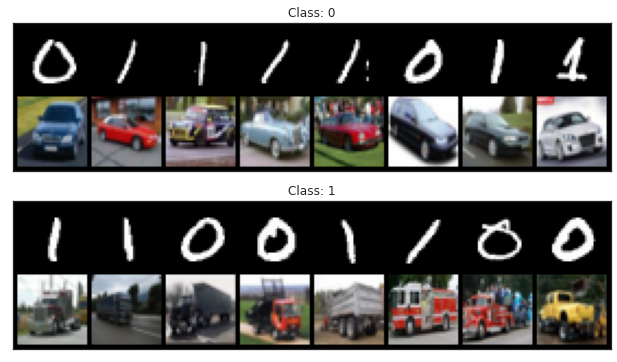

In [50]:
# visualize the MNIST-randomized dataset
_ = utils.visualize_loader_by_class(tem_dl)
None

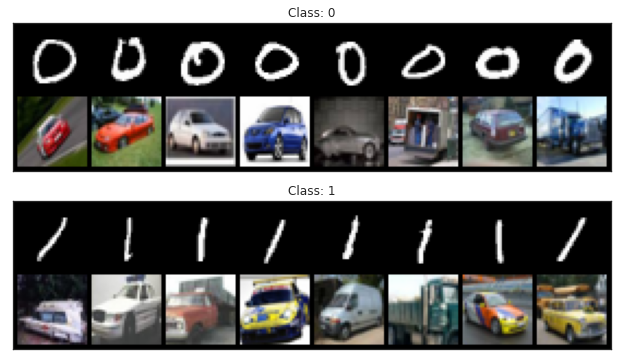

In [51]:
# visualize the CIFAR-randomized dataset
_ = utils.visualize_loader_by_class(tec_dl)
None

## Training a Resnet18 on MNIST-CIFAR data

In [52]:
CE = F.cross_entropy
device = gu.get_device(0) # change GPU device id here 

In [53]:
# Load ResNet and setup optimizer 
def lr_scheduler(epoch):
    if epoch < 30: return 1.0
    if 30 <= epoch: return 0.2
    
get_model = lambda: c10.resnet50(device=device, num_classes=2)
model = get_model().to(device)
opt = optim.SGD(model.parameters(), lr=0.05, weight_decay=5e-5)
sched = optim.lr_scheduler.LambdaLR(opt, lr_scheduler)

In [54]:
# train
stats = utils.fit_model(model, CE, opt, tr_dl, te_dl, device=device, sch=sched,
                        gap=50, patience_updates=1, is_loss_epsilon=True)

accuracy/loss measured every 50 updates
update_print_gap: 50, epss: 0.01, bs: 256, device: cuda:0
#updates, train acc, test acc, train loss
0 0.5018 0.5000 27.4741
50 0.9480 0.9429 0.1446
100 0.9998 0.9990 0.0012
converged after 2 epochs in 0.0m 29.185700s, gap: 0.0008
init-ing patience (1 updates)
101 0.9998 0.9990 0.0013


Standard AUC: 1.000
MNIST-Randomized AUC: 0.511
CIFAR-Randomized AUC: 1.000


Text(0.5, 0.98, 'Logit Distributions of Positive Data')

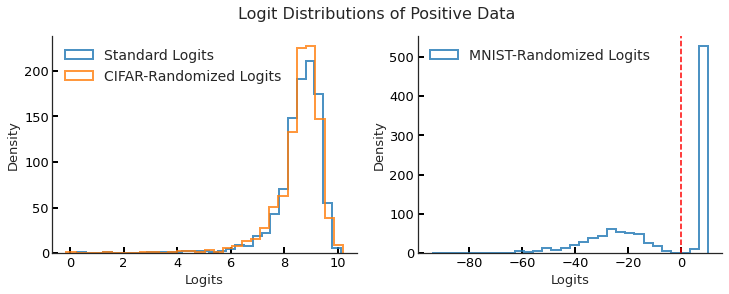

In [56]:
# Compute Standard, MNIST-Randomized and CIFAR-Randomized logits and AUCs

def get_logits(model, loader, device, label=1):
    X, Y = utils.extract_tensors_from_loader(loader)
    L = utils.get_logits_given_tensor(X, model, device=device).detach()
    L = L[Y==label].cpu().numpy()
    S = L[:, 1] - L[:, 0] # compute score / difference to get scalar 
    return S

SCP = {
    'std': get_logits(model, te_dl, device),
    'rand_mnist': get_logits(model, tem_dl, device),
    'rand_cifar': get_logits(model, tec_dl, device),
}

AUC = {
    'std': utils.get_binary_auc(model, te_dl, device),
    'rand_mnist': utils.get_binary_auc(model, tem_dl, device),
    'rand_cifar': utils.get_binary_auc(model, tec_dl,device),
}

print ("Standard AUC: {:.3f}".format(AUC['std']))
print ("MNIST-Randomized AUC: {:.3f}".format(AUC['rand_mnist']))
print ("CIFAR-Randomized AUC: {:.3f}".format(AUC['rand_cifar']))

# standard and randomized positive logit distributions
std_log, sc_log, s_log = SCP['std'], SCP['rand_cifar'], SCP['rand_mnist']

kw = dict(kde=False, bins=30, norm_hist=True, 
          hist_kws={"histtype": "step", "linewidth": 2, "alpha": 0.8, "ls": '-'})

# plot logit distributions
kw = dict(kde=False, bins=30, norm_hist=False, 
          hist_kws={"histtype": "step", "linewidth": 2, 
                    "alpha": 0.8, "ls": '-'})

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
sns.distplot(std_log, label='Standard Logits', ax=ax1, **kw)
sns.distplot(sc_log, label=r'CIFAR-Randomized Logits', ax=ax1, **kw)
sns.distplot(s_log, label=r'MNIST-Randomized Logits', ax=ax2, **kw)
ax2.axvline(x=0, color='red', ls='--')


utils.update_ax(ax1, '', 'Logits', 'Density', 
                ticks_fs=13, label_fs=13, title_fs=16, legend_fs=14, legend_loc='upper left')

utils.update_ax(ax2, '', 'Logits', 'Density', 
                ticks_fs=13, label_fs=13, title_fs=16, legend_fs=14, legend_loc='upper left')

fig.suptitle('Logit Distributions of Positive Data', fontsize=16)

As shown above, randomizing the MNIST block randomly shuffles the positive logits across both class and nullifies the predictive power of models learned via SGD; the AUC of the SGD-trained ResNet drops from $100\%$ to $50\%$ . On the other hand, randomzing the CIFAR (i.e., S^c) block has no effect on AUC or the logit distribution.

## Adversarially Trainining a Resnet50 on MNIST-CIFAR
In this section, we evaluate whether $\ell_{\infty}$ adversarial training mitigates simplicity bias using randomized AUC and logits of resnet18s trained on the MNIST-CIFAR dataset. Increasing the perturbation epsilon either gives the same results or is too large a value for training the model adversarially. In Appendix E.1, we show that our results hold for MobileNetV2, DenseNet121 and ResNet50 as well.

In [57]:
CE = F.cross_entropy
device = gu.get_device(0) # change GPU device id here 

In [58]:
# Load ResNet and setup optimizer 
def lr_scheduler(epoch):
    if epoch < 30: return 1.0
    if 30 <= epoch: return 0.2
    
get_model = lambda: c10.resnet50(device=device, num_classes=2)
model = get_model().to(device)
opt = optim.SGD(model.parameters(), lr=0.05, weight_decay=5e-5)
sched = optim.lr_scheduler.LambdaLR(opt, lr_scheduler)

In [60]:
# adverarially train the model using PGD attacks
bounds = (0., 1.)
adv_epsilon = 0.3
num_iter = 7
attack = pu.Linf_PGD_Attack(adv_epsilon, 0.4*adv_epsilon, num_iter, 
                            'untargeted', bounds=bounds, device=device)

stats = utils.pgd_adv_fit_model(model, opt, tr_dl, te_dl, attack, sch=sched, 
                                device=device, max_epochs=200, epoch_gap=4)

# note: if it has almost converged, you can interrupt and enter Q to 
# stop training or interrupt and change the LR to meet the stopping criterion
# 200 epochs ~ 4 hours on a P100

Min loss: 0.001
Epoch	l-tr	a-tr	a-te	s-te	time
0   0.1548   0.9527   0.7898   0.9980   84.9218
Epoch 0: accuracy 0.953 and loss 0.155
Epoch 1: accuracy 0.952 and loss 0.128
Epoch 2: accuracy 0.964 and loss 0.089
Epoch 3: accuracy 0.955 and loss 0.965
4   0.1168   0.9721   0.9531   0.9990   294.7206
Epoch 4: accuracy 0.972 and loss 0.117
Epoch 5: accuracy 0.978 and loss 0.086
Epoch 6: accuracy 0.974 and loss 0.058
Epoch 7: accuracy 0.964 and loss 0.116
8   0.0764   0.9710   0.9714   0.9995   294.7754
Epoch 8: accuracy 0.971 and loss 0.076
Epoch 9: accuracy 0.977 and loss 0.058
Epoch 10: accuracy 0.979 and loss 0.056
Epoch 11: accuracy 0.977 and loss 0.060
12   0.0914   0.9726   0.9786   0.9995   294.5161
Epoch 12: accuracy 0.973 and loss 0.091
Epoch 13: accuracy 0.983 and loss 0.045
Epoch 14: accuracy 0.985 and loss 0.041
Epoch 15: accuracy 0.984 and loss 0.045
16   0.0395   0.9842   0.9566   0.9990   294.4902
Epoch 16: accuracy 0.984 and loss 0.039
Epoch 17: accuracy 0.982 and loss 0.0

Epoch 155: accuracy 0.993 and loss 0.020
156   0.0185   0.9941   0.9816   0.9995   294.2832
Epoch 156: accuracy 0.994 and loss 0.019
Epoch 157: accuracy 0.993 and loss 0.020
Epoch 158: accuracy 0.992 and loss 0.020
Epoch 159: accuracy 0.993 and loss 0.020
160   0.0193   0.9931   0.9918   1.0000   294.2994
Epoch 160: accuracy 0.993 and loss 0.019
Epoch 161: accuracy 0.994 and loss 0.019
Epoch 162: accuracy 0.992 and loss 0.019
Epoch 163: accuracy 0.993 and loss 0.020
164   0.0198   0.9936   0.9929   1.0000   294.3328
Epoch 164: accuracy 0.994 and loss 0.020
Epoch 165: accuracy 0.993 and loss 0.019
Epoch 166: accuracy 0.994 and loss 0.018
Epoch 167: accuracy 0.994 and loss 0.018
168   0.0198   0.9922   0.9878   0.9995   294.3546
Epoch 168: accuracy 0.992 and loss 0.020
Epoch 169: accuracy 0.993 and loss 0.020
Epoch 170: accuracy 0.993 and loss 0.019
Epoch 171: accuracy 0.994 and loss 0.019
172   0.0183   0.9936   0.9929   1.0000   294.4909
Epoch 172: accuracy 0.994 and loss 0.018
Epoch 1

Standard AUC: 1.000
MNIST-Randomized AUC: 0.508
CIFAR-Randomized AUC: 1.000


Text(0.5, 0.98, 'Logit Distributions of Positive Data')

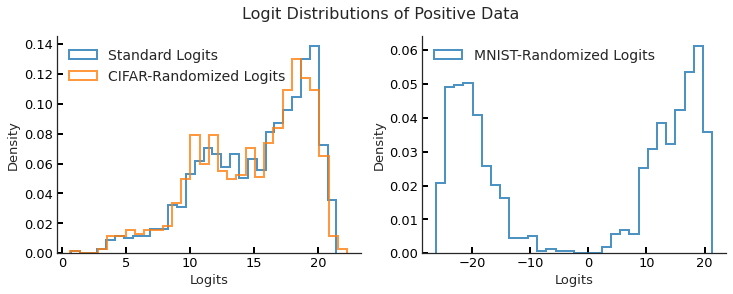

In [62]:
# pick best performing model based on validation accuracy
model = stats['best_model'][-1].to(device)

# Compute Standard, MNIST-Randomized and CIFAR-Randomized logits and AUCs

def get_logits(model, loader, device, label=1):
    X, Y = utils.extract_tensors_from_loader(loader)
    L = utils.get_logits_given_tensor(X, model, device=device).detach()
    L = L[Y==label].cpu().numpy()
    S = L[:, 1] - L[:, 0] # compute score / difference to get scalar 
    return S

SCP = {
    'std': get_logits(model, te_dl, device),
    'rand_mnist': get_logits(model, tem_dl, device),
    'rand_cifar': get_logits(model, tec_dl, device),
}

AUC = {
    'std': utils.get_binary_auc(model, te_dl, device),
    'rand_mnist': utils.get_binary_auc(model, tem_dl, device),
    'rand_cifar': utils.get_binary_auc(model, tec_dl,device),
}

print ("Standard AUC: {:.3f}".format(AUC['std']))
print ("MNIST-Randomized AUC: {:.3f}".format(AUC['rand_mnist']))
print ("CIFAR-Randomized AUC: {:.3f}".format(AUC['rand_cifar']))

# standard and randomized positive logit distributions
std_log, sc_log, s_log = SCP['std'], SCP['rand_cifar'], SCP['rand_mnist']

kw = dict(kde=False, bins=30, norm_hist=True, 
          hist_kws={"histtype": "step", "linewidth": 2, "alpha": 0.8, "ls": '-'})

# plot logit distributions
kw = dict(kde=False, bins=30, norm_hist=True, 
          hist_kws={"histtype": "step", "linewidth": 2, 
                    "alpha": 0.8, "ls": '-'})

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
sns.distplot(std_log, label='Standard Logits', ax=ax1, **kw)
sns.distplot(sc_log, label=r'CIFAR-Randomized Logits', ax=ax1, **kw)
sns.distplot(s_log, label=r'MNIST-Randomized Logits', ax=ax2, **kw)

utils.update_ax(ax1, '', 'Logits', 'Density', 
                ticks_fs=13, label_fs=13, title_fs=16, legend_fs=14, legend_loc='upper left')

utils.update_ax(ax2, '', 'Logits', 'Density', 
                ticks_fs=13, label_fs=13, title_fs=16, legend_fs=14, legend_loc='upper left')

fig.suptitle('Logit Distributions of Positive Data', fontsize=16)